In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
from random import randint
import uuid,json
import matplotlib.pyplot as plt
    
from quinine import QuinineArgumentParser
from tqdm import tqdm
import torch
import yaml
import numpy as np
from eval import get_run_metrics
from tasks import get_task_sampler
from samplers import get_data_sampler
from curriculum import Curriculum
from schema_eval import schema
from schema import TASK_TO_DATA
from models import build_model
import random
from functools import wraps
from eval import get_run_metrics, read_run_dir, get_model_from_run
from plot_utils import basic_plot, collect_results
from evaluate_ode import get_paras, calculate_error_stats, plot_comparison, plot_error_analysis, generate_equation_params, get_steps

run_dir = "../../models12"

In [3]:
df = df = read_run_dir(run_dir)
df

run_path: ../../models12/ode_ivp_case2/9a20d467-9e5a-4883-9b98-2e4a141e55e3
run_path: ../../models12/ode_ivp_case2/83537d68-2a0b-4203-bae8-2436022f22a5
run_path: ../../models12/ode_ivp_case2vec_valid_layer24/63c577f5-86a4-40a0-a9de-0dae6ab109c5
run_path: ../../models12/ode_ivp_case2vec_valid_layer24/57654663-c4b8-4f5b-9336-44631ff33875
run_path: ../../models12/ode_ivp_case2vec_valid_layer24/dfaed326-a2a7-4bc6-aff7-6e68d5ebeca2
run_path: ../../models12/ode_ivp_case2vec_valid_layer24/15b8b341-cc45-475e-af48-4092a345f638
run_path: ../../models12/ode_ivp_case2vec_valid/a60e3ec6-223c-4b95-8fe3-8fdc0b5196da
run_path: ../../models12/ode_ivp_case2vec_valid/c80b634b-9003-4d46-998c-9985ddcd28e9
run_path: ../../models12/ode_ivp_case2vec_valid/f409869b-cfcf-4aca-bb72-454fb1b84e3c
run_path: ../../models12/ode_ivp_case2vec_valid/23aafa8d-fd90-4d39-b266-527a8e27657b
run_path: ../../models12/ode_ivp_case1plus/282a9fa2-268d-4397-a03d-fca6ce75675f
run_path: ../../models12/ode_ivp_case1/24c1872a-7ff7-427

,run_id,task,model,steps,num_tasks,num_examples,n_dims,n_layer,n_head,run_name,kwargs
17,cf0e52d6-7902-425c-8ccb-f2d52004b686,longrun_ode_ivp_case2_layer24,Transformer-12 layers,20000001,-1,-1,50,24,8,longrun_ode_ivp_case2_layer24,
26,d2f56364-4349-45ac-a123-13efa50db576,ode_ivp_case1plus_enhancedloss,Transformer,200001,-1,-1,20,12,8,ode_ivp_case1_plus_enhancedloss_run1,
20,b895f496-ad85-4545-a100-212c99ea9341,ode_ivp_case1plus_valid,Transformer,200001,-1,-1,20,12,8,ode_ivp_case1_plus_valid_run_01,
18,c3e94367-a517-47de-9eae-f74b3e1abd80,ode_ivp_case1plus_valid,Transformer,200001,-1,-1,20,12,8,ode_ivp_case1_plus_valid_run_11,
11,24c1872a-7ff7-427f-9d41-ff57d6b7ee1f,ode_ivp_case1,Transformer,500001,-1,-1,20,12,8,ode_ivp_case1_run3,
27,d99eaaaa-791d-465c-8eb3-9a44b9faa660,ode_ivp_case1plus_enhancedloss,Transformer,200001,-1,-1,50,12,8,ode_ivp_case1plus_enhancedloss_run_0303,
24,ac0443e1-12d4-4fe5-9f23-998216b35556,ode_ivp_case1plus_h_enhancedloss,Transformer,200001,-1,-1,50,12,8,ode_ivp_case1plus_h_enhancedloss_run_015,
15,591e2f19-6813-4881-a30f-21f4a579e8ed,ode_ivp_case1plus_h_valid,Transformer,200001,-1,-1,50,12,8,ode_ivp_case1plus_h_valid_run_01,
13,de07feef-381a-4ead-843e-3283eb5588d2,ode_ivp_case1plus_h_valid,Transformer,200001,-1,-1,50,12,8,ode_ivp_case1plus_h_valid_run_02,
14,2fde25f5-5b9d-4ff6-a914-6b28b0ea5a98,ode_ivp_case1plus_h_valid,Transformer,200001,-1,-1,50,12,8,ode_ivp_case1plus_h_valid_run_11,


In [4]:
# 选择模型
run_names = [
    "ode_ivp_case2fin_valid_layer12",
    "ode_ivp_case2fin_valid_layer24",
]
run_id = [
    "8f4129a9-d210-41fd-a0f2-4c17c633da9d",
    "9c8e476e-df17-4ebe-b7ff-b5fdaccdd063",
    ]
output_labels = [
    "ode_ivp_case2fin_valid_layer12",
    "ode_ivp_case2fin_valid_layer24",
    ]
run_paths = [os.path.join(run_dir, output_label, run_id) for run_id, output_label in zip(run_id, output_labels)]


## Out of distributions

### 1.shifted parameters

#### 1.a all shifted parameters

In [5]:
# 从第一个模型中获取参数,创建任务采样器和数据采样器
_ , conf = get_model_from_run(run_paths[0])
n_dims = conf.model.n_dims
batch_size = conf.training.batch_size
n_points = conf.training.curriculum.points.end
data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    conf.training.task,
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)
task = task_sampler()

run_path: ../../models12/ode_ivp_case2fin_valid_layer12/8f4129a9-d210-41fd-a0f2-4c17c633da9d


In [ ]:
allshift_xss = []
allshift_yss = []
y_models = {}
error_models = {}
rangeset = range(1, 11)
stable_para = {
    'a_1': (-1, -1),
    'a_2': (0.5, 0.5),      # 增大系数
    'b_1': (-1, -1),    # 中等强度激励项
    'b_2': (1.28, 1.28),
    'y_0': (0.5, 0.5),
    't_e': (2.0, 2.0),    # 固定时间范围
    'steps': (10, n_dims-10)      # 步数范围对应h=0.2~0.025
}
testdata_scale = 30
shiftvalues = np.linspace(-2, 2, testdata_scale)
shiftvaluename = 'a_1'
for i in range(testdata_scale):
    shift_para = {
        'a_1': (shiftvalues[i], shiftvalues[i]),
        'a_2': (0.5, 0.5) ,      # 增大系数
        'b_1': (-1, -1),    # 中等强度激励项
        'b_2': (1.28, 1.28),
        'y_0': (0.5, 0.5),
        't_e': (2.0, 2.0),    # 固定时间范围
        'steps': (5, n_dims-5)
    }
    xs = data_sampler.continuous_sample_xs(b_size=batch_size, n_points=n_points,shifted_paras=shift_para)
    ys = task.evaluate(xs)
    allshift_xss.append(xs)
    allshift_yss.append(ys)

In [7]:
k = 0
for run_path in tqdm(run_paths):
    model, _ = get_model_from_run(run_path)
    model.eval()
    model.cuda()
    with torch.no_grad():
        outs = []
        errors = []
        for xs, ys in zip(allshift_xss, allshift_yss):
            xs, ys = xs.cuda(), ys.cuda()
            output = model(xs, ys)
            steps = get_steps(conf.training.data, xs)
    
            # 创建mask矩阵，steps范围外设为0
            mask = torch.zeros_like(output)
            for i in range(output.shape[0]):
                for j in range(output.shape[1]):
                    mask[i, j, :steps[i, j]] = 1

            diff = torch.abs(output - ys) * mask
            error = torch.sum(diff, dim=-1) / steps
            errors.append(error)
            outs.append(output)
    y_models[run_names[k]] = outs
    error_models[run_names[k]] = errors
    y_models[run_names[k]] = np.array([tensor.cpu().numpy() for tensor in y_models[run_names[k]]])
    error_models[run_names[k]] = np.array([tensor.cpu().numpy() for tensor in error_models[run_names[k]]])
    k += 1
     

  0%|          | 0/2 [00:00<?, ?it/s]

run_path: ../../models12/ode_ivp_case2fin_valid_layer12/8f4129a9-d210-41fd-a0f2-4c17c633da9d


 50%|█████     | 1/2 [00:03<00:03,  3.11s/it]

run_path: ../../models12/ode_ivp_case2fin_valid_layer24/9c8e476e-df17-4ebe-b7ff-b5fdaccdd063


100%|██████████| 2/2 [00:06<00:00,  3.15s/it]


In [8]:
# classic_typs = ["euler_explicit","euler_implicit","RK23","euler_improved","euler_adaptive", "BDF"]
classic_typs = ["euler_explicit","euler_implicit"] 
y_classic = {}
error_classic = {}
for typ in tqdm(classic_typs):
    task_sampler_classic = get_task_sampler(
        "ode_ivp_case2BSL",
        n_dims,
        batch_size
    )
    task_classic = task_sampler_classic()
    outs = []
    errors = []
    for xs, ys in zip(allshift_xss, allshift_yss):
        output = task_classic.evaluate(xs, method=typ)
        steps = get_steps(conf.training.data, xs)
    
        # 创建mask矩阵，steps范围外设为0
        mask = torch.zeros_like(output)
        for i in range(output.shape[0]):
            for j in range(output.shape[1]):
                mask[i, j, :steps[i, j]] = 1

        diff = torch.abs(output - ys) * mask
        error = torch.sum(diff, dim=-1) / steps
        errors.append(error)
        outs.append(output)
    y_classic[typ] = outs
    error_classic[typ] = errors
    y_classic[typ] = np.array([tensor.cpu().numpy() for tensor in y_classic[typ]]) 
    error_classic[typ] = np.array([tensor.cpu().numpy() for tensor in error_classic[typ]])

 50%|█████     | 1/2 [00:23<00:23, 23.55s/it]/mnt/data/ziyang/project/src/tasks.py:631: RuntimeWarning: divide by zero encountered in double_scalars
  y_next = numerator / denominator
100%|██████████| 2/2 [00:43<00:00, 21.83s/it]


In [9]:
steps

tensor([[ 5,  6,  7,  ..., 43, 44, 45],
        [ 5,  6,  7,  ..., 43, 44, 45],
        [ 5,  6,  7,  ..., 43, 44, 45],
        ...,
        [ 5,  6,  7,  ..., 43, 44, 45],
        [ 5,  6,  7,  ..., 43, 44, 45],
        [ 5,  6,  7,  ..., 43, 44, 45]], device='cuda:0')

#### 画图

In [10]:
error_classic['euler_explicit'].shape

(30, 64, 41)

In [11]:
# 保存评估结果路径
fig_dir_raw = "../figs"
print(f"Save figures to {fig_dir_raw}")

Save figures to ../figs


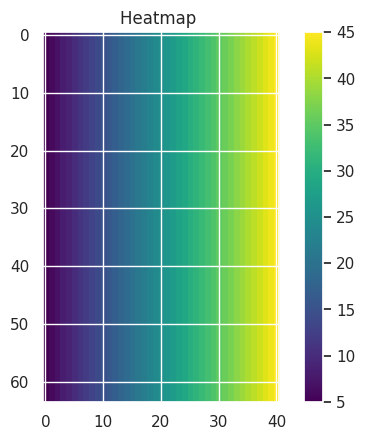

In [12]:
stepshape = allshift_xss[0][:,:,6].cpu().numpy()
plt.imshow(stepshape, cmap='viridis', interpolation='nearest')
plt.colorbar()  
plt.title(f'Heatmap ')
plt.show()

In [13]:
log_error_classic = {
    'euler_explicit': np.log(error_classic['euler_explicit']),
    'euler_implicit': np.log(error_classic['euler_implicit']),
    }
log_error_models = {
    }
log_error_models = {key: np.log(value) for key, value in error_models.items()}
error_models

{'ode_ivp_case2fin_valid_layer12': array([[[5.4571795 , 8.277092  , 3.566487  , ..., 0.6697777 ,
          0.6787945 , 0.65849566],
         [5.4571795 , 8.277092  , 3.566487  , ..., 0.6697777 ,
          0.6787945 , 0.65849566],
         [5.4571795 , 8.277092  , 3.566487  , ..., 0.6697777 ,
          0.6787945 , 0.65849566],
         ...,
         [5.4571795 , 8.277092  , 3.566487  , ..., 0.6697777 ,
          0.6787945 , 0.65849566],
         [5.4571795 , 8.277092  , 3.566487  , ..., 0.6697777 ,
          0.6787945 , 0.65849566],
         [5.4571795 , 8.277092  , 3.566487  , ..., 0.6697777 ,
          0.6787945 , 0.65849566]],
 
        [[3.5046635 , 5.860584  , 2.2700253 , ..., 0.555385  ,
          0.54505974, 0.52078485],
         [3.5046635 , 5.860584  , 2.2700253 , ..., 0.555385  ,
          0.54505974, 0.52078485],
         [3.5046635 , 5.860584  , 2.2700253 , ..., 0.555385  ,
          0.54505974, 0.52078485],
         ...,
         [3.5046635 , 5.860584  , 2.2700253 , ..., 0.

ode_ivp_case2fin_valid_layer12


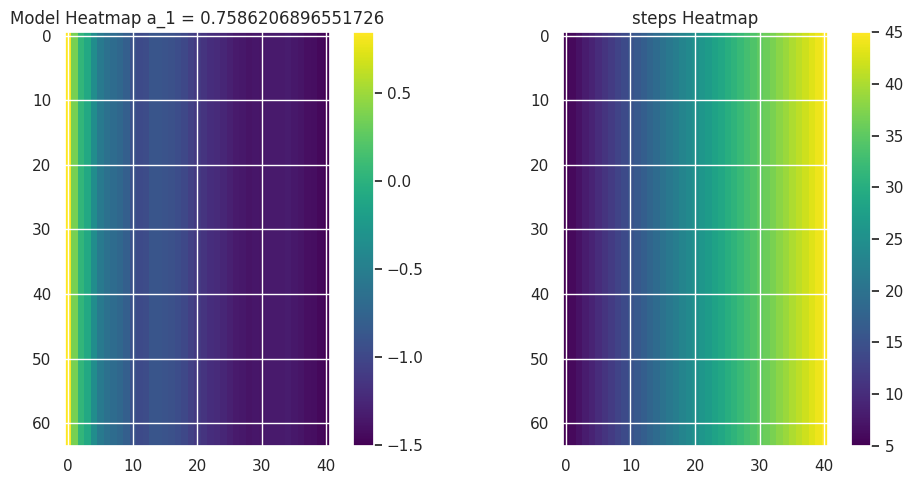

ode_ivp_case2fin_valid_layer24


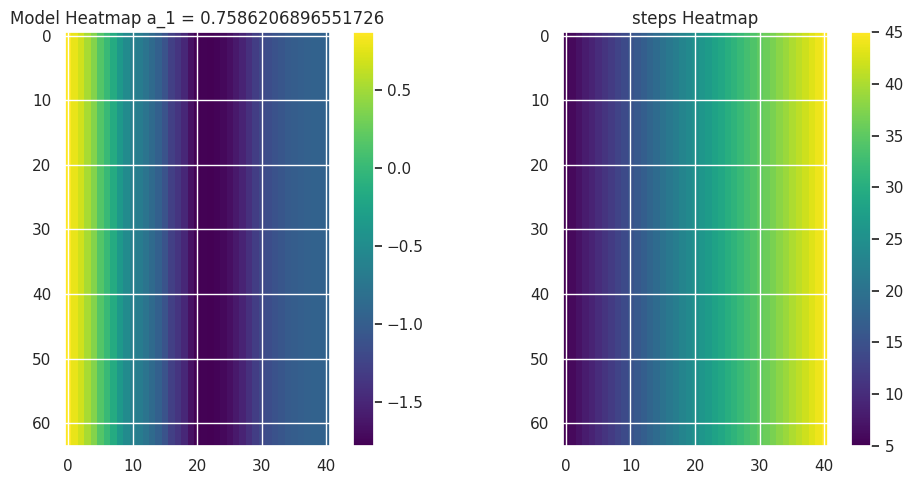

In [14]:
ind = 20
fig_dir_base = fig_dir_raw
for key, value in log_error_models.items():
    print(key)
    fig_dir = os.path.join(fig_dir_base, key)
# 确保图片目录存在
    os.makedirs(fig_dir, exist_ok=True)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    equation_title, filename_params, h_full, steps_full = generate_equation_params(conf, xs, n_points)
    # 
    data1 = value[ind]
    # data1 = log_error_classic['euler_explicit'][ind]
    im1 = ax1.imshow(data1, cmap='viridis', interpolation='nearest')
    fig.colorbar(im1, ax=ax1)
    ax1.set_title(f'Model Heatmap {shiftvaluename} = {shiftvalues[ind]}')

    # 第二张热图
    im2 = ax2.imshow(stepshape, cmap='viridis', interpolation='nearest')
    fig.colorbar(im2, ax=ax2)
    ax2.set_title(f'steps Heatmap')

    plt.tight_layout()
    plt.savefig(os.path.join(fig_dir, f"log_error_heatmap_{shiftvaluename}_{filename_params}.pdf"))
    plt.show()
fig_dir = fig_dir_base


In [15]:
log_error_models['ode_ivp_case2fin_valid_layer12'].shape

(30, 64, 41)

(30, 41)


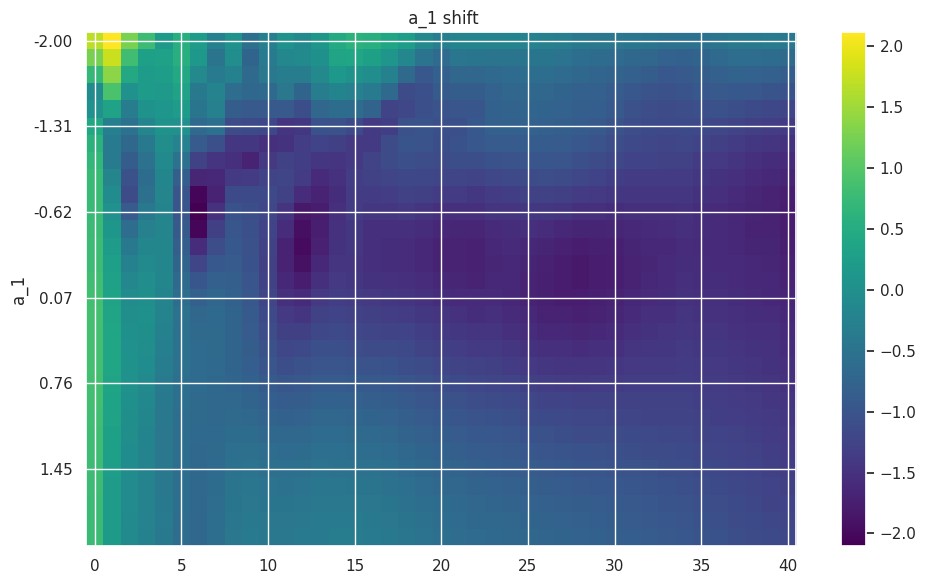

(30, 41)


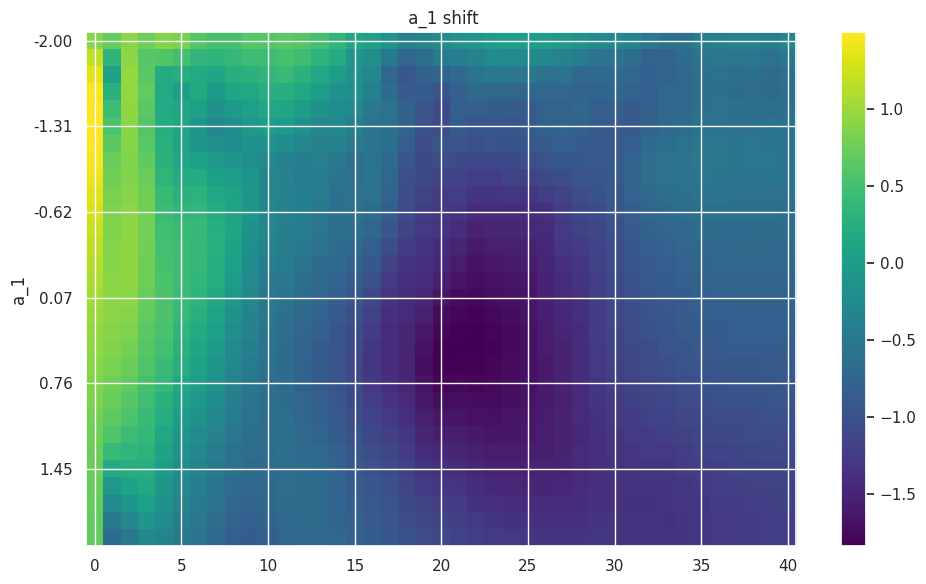

In [16]:
special_npoints = 0
fig_dir_base = fig_dir_raw
for key, value in log_error_models.items():
    data = value[:,special_npoints,:]
    print(data.shape)
    fig_dir = os.path.join(fig_dir_base, key)
    plt.figure(figsize=(10, 6))
    im = plt.imshow(data, cmap='viridis', interpolation='nearest', aspect='auto')

    # 设置横轴刻度为shiftvalues
    tick_step = 5  # 设置刻度间隔
    plt.yticks(range(0, len(shiftvalues), tick_step), 
            [f"{shiftvalues[i]:.2f}" for i in range(0, len(shiftvalues), tick_step)])
    plt.ylabel(f'{shiftvaluename}')

    plt.colorbar(im)  # 添加颜色条以显示数值范围
    plt.title(f' {shiftvaluename} shift')
    plt.tight_layout()
    plt.savefig(os.path.join(fig_dir, f"{shiftvaluename}_shift_log_error_{filename_params}_npoints_{special_npoints}.pdf"))
    plt.show()